In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV

random_state = 2023

In [2]:
train_data_path = join('./data', 'train.csv')
sub_data_path = join('./data', 'test.csv')

## 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [3]:
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


## - 데이터 전처리

In [4]:
#train data에서 타겟('price') 분리

y = data['price']

del data['price']

In [5]:
#train data와 test data를 동시에 전처리 하기 위해 합쳐주는 작업

train_len = len(data)
data = pd.concat((data, sub), axis=0)

In [6]:
# 'date' 컬럼의 데이터 형태 변화

data['date'] = data['date'].apply(lambda i: i[:6]).astype(int)

# 'id' 컬럼 제거

sub_id = data['id'][train_len:]
del data['id']

data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [7]:
data.shape

(21503, 19)

### 각 변수들의 분포 확인
한쪽으로 치우친 분포는 모델이 결과를 예측하기에 좋지 않은 영향을 미치므로 다듬어줄 필요가 있습니다.

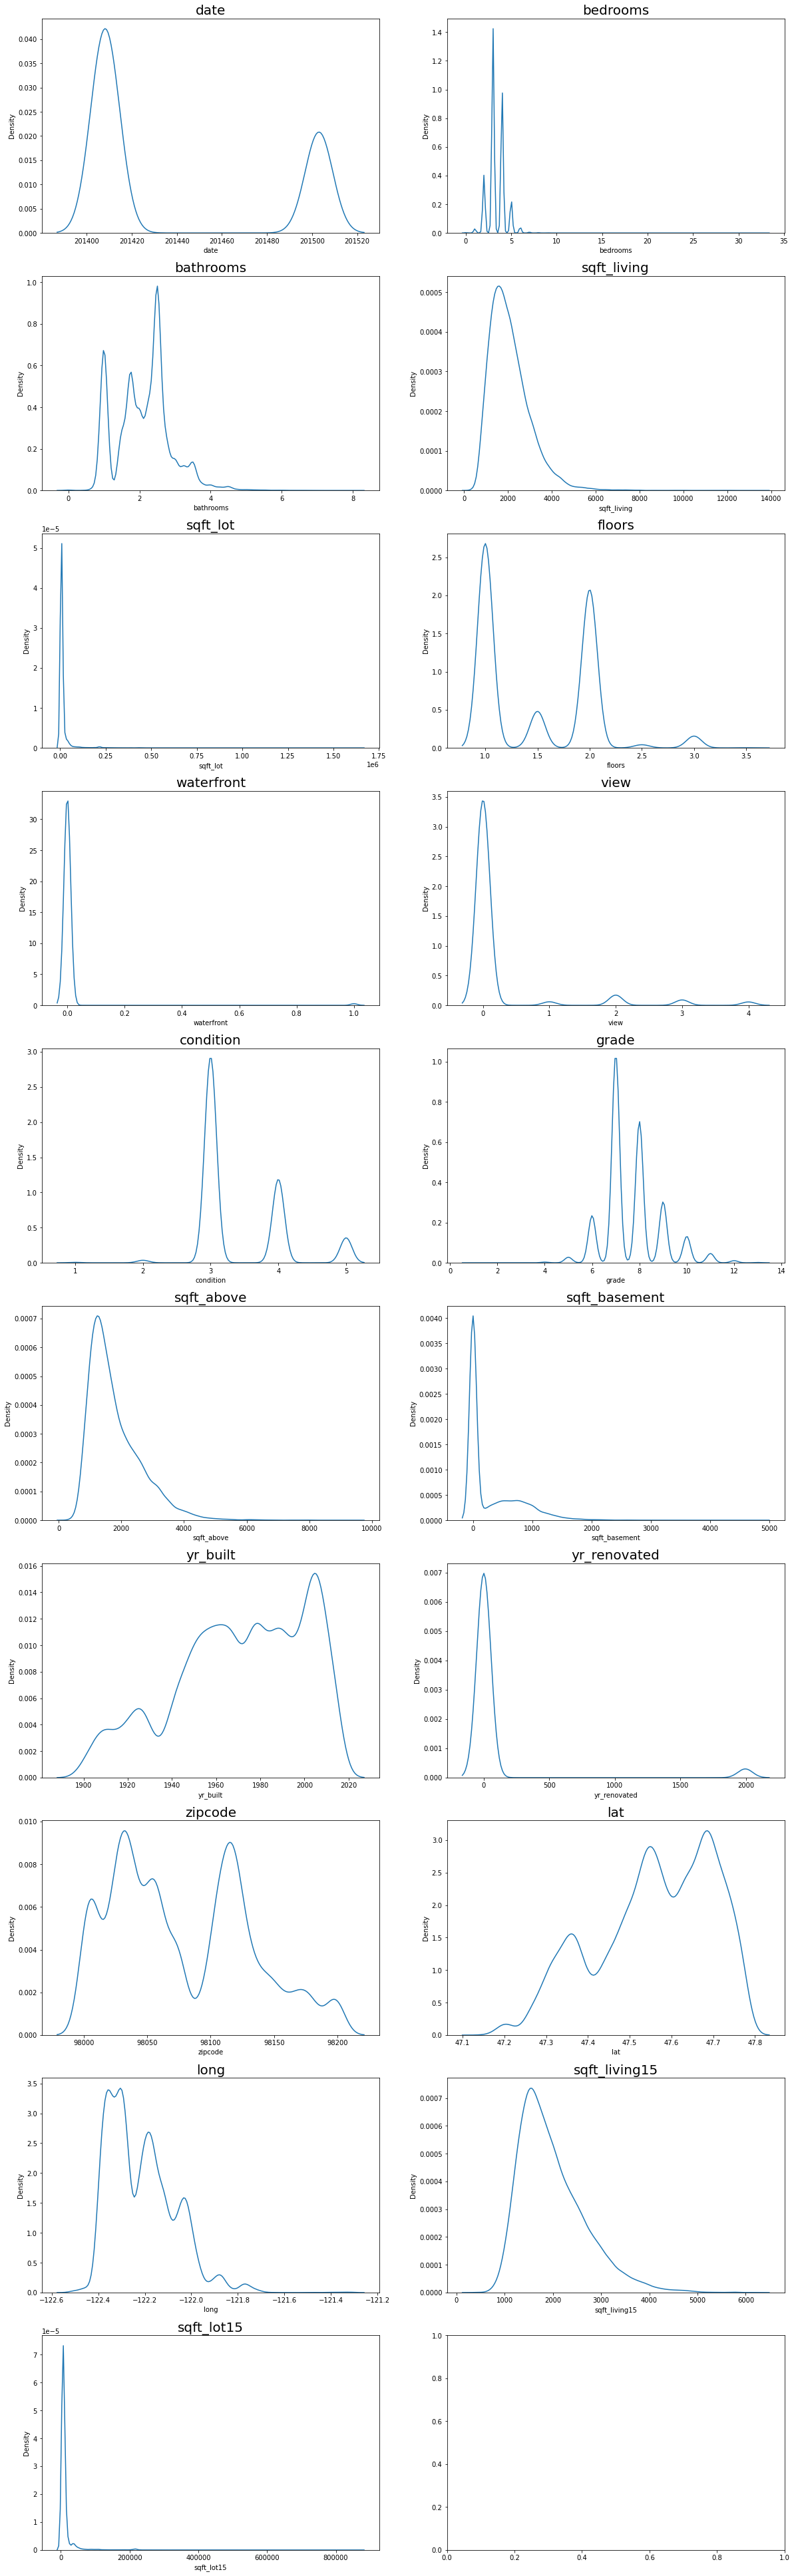

In [8]:
fig, ax = plt.subplots(10, 2, figsize=(20, 70))

count = 0
columns = data.columns
for row in range(10):
    for col in range(2):
        sns.kdeplot(data = data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=20)
        count+=1
        if count == 19:
            break

### price, bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement  - log-scaling 전처리

다음 변수들이 한쪽으로 치우친 경향을 보였습니다.<br>
log-scaling을 통해 데이터 분포를 정규분포에 가깝게 만들어 보겠습니다.

In [9]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

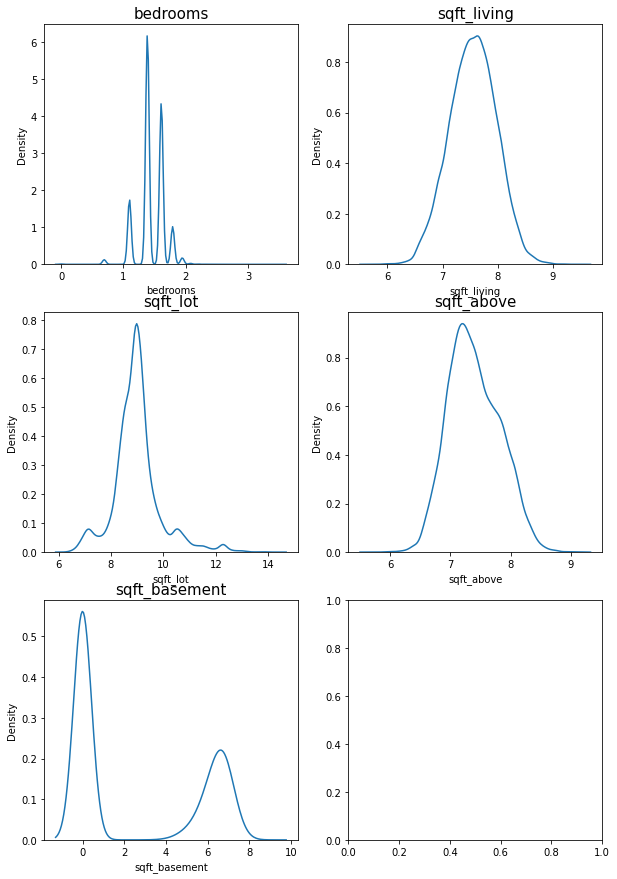

In [10]:
fig, ax = plt.subplots(3, 2, figsize=(10, 15))

count = 0
for row in range(3):
    for col in range(2):
        if count == 5:
            break
        sns.kdeplot(data = data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count+=1



어느정도 치우침이 줄어든 분포를 확인할 수 있습니다.

### date, yr_built, zipcode, lat, long - min_max scale 전처리

In [11]:
skew_columns = ['date', 'yr_built', 'zipcode', 'lat', 'long']

for c in skew_columns:
    min = np.min(data[c])
    max = np.max(data[c])
    data[c] = (data[c]-min)/(max-min)

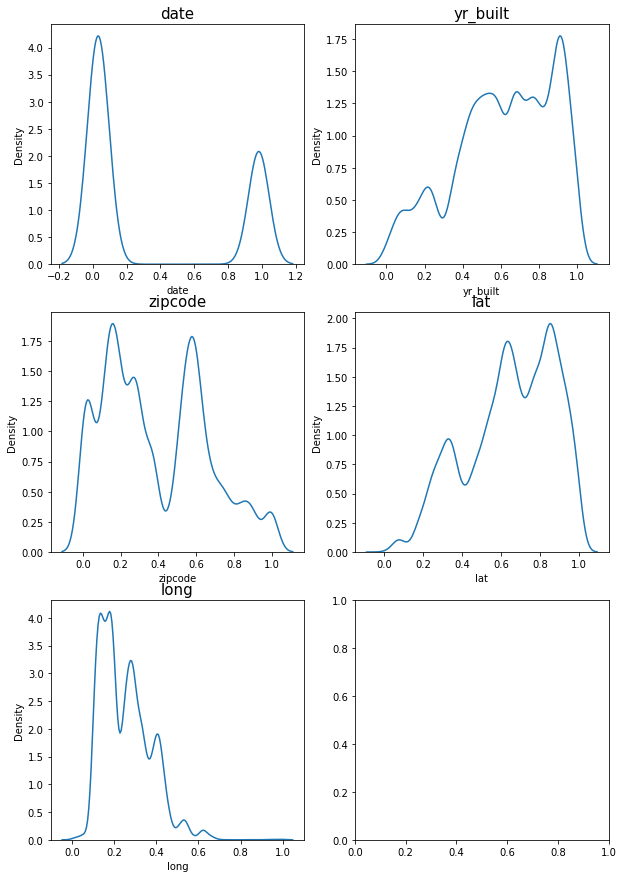

In [12]:
fig, ax = plt.subplots(3, 2, figsize=(10, 15))

count = 0
for row in range(3):
    for col in range(2):
        if count == 5:
            break
        sns.kdeplot(data = data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count+=1

## train set, submission set 분리

In [27]:
submission = np.array(data.iloc[train_len:, :])
train = np.array(data.iloc[:train_len, :])
print(submission.shape)


(6468, 19)


### target data 로그변환

(15035,)


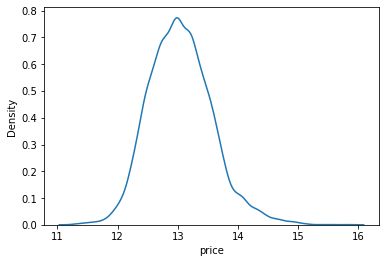

In [14]:
# 원 데이터 price가 한쪽으로 치우쳐져있었기 때문에 normalization을 거쳤다

y = np.log1p(y)
sns.kdeplot(data = y)

print(y.shape)

## 모델 후보들과 하이퍼 파라미터 그리드

모델 후보들로는 GradientBoostingRegressor, xgboost, lightgbm 가 있다.

파라미터 그리드:

- n_estimators - 트리의 개수 (기본값: 100)
- max_depth - 트리의 최대 깊이 (기본값: 3)
- learning_rate - 각 트리의 기여도를 조절하는 학습률 (기본값: 0.1)

In [16]:
gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)


# models = [gboost, xgboost, lightgbm] : 해본 결과 ligthgbm & xgboost 선택

models = [lightgbm, xgboost]

# hyper parameter grids

param_grid = {
    'n_estimators': [500, 1000], #n_estimator를 크게 잡는 경우가 많았다
    'max_depth': [5, 10],  # depth를 굳이 깊이 잡는 것 같지 않았다
    'learning_rate': [0.1] #learning rate은 0.1로 선택
}


### 다중 모델 gridsearch -> model & parameter selection

In [18]:
def my_GridSearch(models, train, y, param_grid, verbose=2, n_jobs=5):
    results = pd.DataFrame()
    for model in models:
        model_name = model.__class__.__name__
        grid_model = GridSearchCV(model, param_grid=param_grid, \
                                  scoring='neg_mean_squared_error', \
                                  cv=5, verbose=verbose, n_jobs=n_jobs)
        grid_model.fit(train, y)

        params = grid_model.cv_results_['params']
        score = grid_model.cv_results_['mean_test_score']
        
        tmp = pd.DataFrame(params)
        tmp['score'] = score
        tmp['RMSLE'] = np.sqrt(-1 * score)
        tmp['model'] = model_name
        results = pd.concat([results, tmp])

    results_sorted = results.sort_values(by=['RMSLE'])

    return results_sorted


In [19]:
my_GridSearch(models, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits


/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warni

[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=500; total time=   5.9s
[CV] END ..learning_rate=0.1, max_depth=5, n_estimators=1000; total time=  10.0s
[CV] END ..learning_rate=0.1, max_depth=10, n_estimators=500; total time=   6.9s
[CV] END .learning_rate=0.1, max_depth=10, n_estimators=1000; total time=  13.6s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=500; total time= 3.0min
[CV] END ..learning_rate=0.1, max_depth=5, n_estimators=1000; total time= 7.4min
[CV] END ..learning_rate=0.1, max_depth=10, n_estimators=500; total time= 7.9min
[CV] END .learning_rate=0.1, max_depth=10, n_estimators=1000; total time=13.1min
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=500; total time=   3.6s
[CV] END ..learning_rate=0.1, max_depth=5, n_estimators=1000; total time=  12.5s
[CV] END ..learning_rate=0.1, max_depth=10, n_estimators=500; total time=   8.0s
[CV] END .learning_rate=0.1, max_depth=10, n_estimators=1000; total time=  12.9s
[CV] END ...learning_rate=0.

,learning_rate,max_depth,n_estimators,score,RMSLE,model
0,0.1,5,500,-0.026188,0.161827,XGBRegressor
2,0.1,10,500,-0.026228,0.161952,LGBMRegressor
1,0.1,5,1000,-0.026409,0.162510,XGBRegressor
0,0.1,5,500,-0.026560,0.162972,LGBMRegressor
3,0.1,10,1000,-0.026691,0.163373,LGBMRegressor
1,0.1,5,1000,-0.026854,0.163870,LGBMRegressor
2,0.1,10,500,-0.026945,0.164150,XGBRegressor
3,0.1,10,1000,-0.026976,0.164244,XGBRegressor


### Selected models & hyper parameters

- model : LGBMRegressor
- learning_rate : 0.1
- max_depth : 10, 5
- n_estimators : 500


- model : XGBRegressor
- max_depth : 5
- n_estimators : 500, 1000


In [28]:
# RMSLE score가 좋았던 상위 4개 모델&파라미터 조합을 앙상블하여 예측한다

ensemble_model1 = LGBMRegressor(learning_rate = 0.1, max_depth = 10, n_estimators = 500, random_state=random_state)
ensemble_model2 = XGBRegressor(max_depth = 5, n_estimators = 500, random_state=random_state)
ensemble_model3 = LGBMRegressor(learning_rate = 0.1, max_depth = 5, n_estimators = 500, random_state=random_state)
ensemble_model4 = XGBRegressor(max_depth = 5, n_estimators = 1000, random_state=random_state)

ensemble_model1.fit(train, y)
ensemble_model2.fit(train, y)
ensemble_model3.fit(train, y)
ensemble_model4.fit(train, y)

prediction1 = ensemble_model1.predict(submission)
prediction1 = np.expm1(prediction1)

prediction2 = ensemble_model2.predict(submission)
prediction2 = np.expm1(prediction2)

prediction3 = ensemble_model3.predict(submission)
prediction3 = np.expm1(prediction3)

prediction4 = ensemble_model4.predict(submission)
prediction4 = np.expm1(prediction4)

prediction = (prediction1 + prediction2 + prediction3 + prediction4)/4

In [29]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission_ = pd.read_csv(submission_path)
submission_.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [30]:
submission_['price'] = prediction
submission_.head()

,id,price
0,15035,5.380825e+05
1,15036,4.774215e+05
2,15037,1.328381e+06
3,15038,3.004114e+05
4,15039,3.305863e+05


In [32]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, '2lgbm+2xgbr', '0.1618')
submission_.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission_2lgbm+2xgbr_RMSLE_0.1618.csv


<img src='https://drive.google.com/uc?export=download&id=1NIrxw0BJig-2GDTn0kU7pNsGe1m8jz7e' width="" height ="" /><br>

- (score < 110000) = True 